In [58]:
import os
import gc
import numpy as np 
import pandas as pd
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16 as tmodel_vgg16
from keras.applications.xception import Xception 
from keras.applications.resnet50 import ResNet50 as resnet50
from keras.applications.resnet50 import preprocess_input
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,MaxPooling2D
from keras.models import Sequential, Model 
import datetime as dt

from keras.optimizers import SGD,Adam
from keras.layers import Input,SeparableConv2D,Conv2D
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from keras import backend as K
from keras.layers import MaxPool2D,concatenate
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
from keras.callbacks import EarlyStopping,CSVLogger,ReduceLROnPlateau,TensorBoard
from keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import plot_model

print(os.listdir("../input"))
print("Models Loaded")

['monkey_labels.txt', 'validation', 'training']
Models Loaded


In [42]:
batchsize=10
imgsize=150
height,width,channels=150,150,3
targetsize=(150,150)
inputshape=(150,150,3)
batch_size=16
seed=69
lr = Adam(lr=1e-3)
classes = 10
steps = 30
epochs = 10

print("Model Loaded")
print("HyperParameters Ready")

Model Loaded
HyperParameters Ready


In [ ]:
trn_dir = '../input/training/training'
val_dir = '../input/validation/validation'

classes = pd.read_csv("../input/monkey_labels.txt")
monkey_classes = classes['Label'].size
classes

In [71]:
trn_augs = ImageDataGenerator(preprocessing_function=preprocess_input,
                                              horizontal_flip = True,
                                              width_shift_range = 0.2,
                                              height_shift_range = 0.2)
            
val_augs = ImageDataGenerator(preprocessing_function=preprocess_input)

trn_gen = trn_augs.flow_from_directory(
       directory = trn_dir,
       target_size=(224,224),
       batch_size=24,
       class_mode='categorical')

val_gen = val_augs.flow_from_directory(
       directory = val_dir,
       target_size=(224,224),
       class_mode='categorical')
print("Augmentation Complete")

Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.
Augmentation Complete


In [72]:
# num_classes is the number of categories your model chooses between for each prediction
classes = 10
tmodel = Sequential()
tmodel.add(resnet50(include_top=False, pooling='avg', weights='imagenet'))
tmodel.add(Dropout(0.5))
tmodel.add(Dense(classes, activation='softmax',name='classifier'))

tmodel.layers[0].trainable = False
tmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
classifier (Dense)           (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


Complete


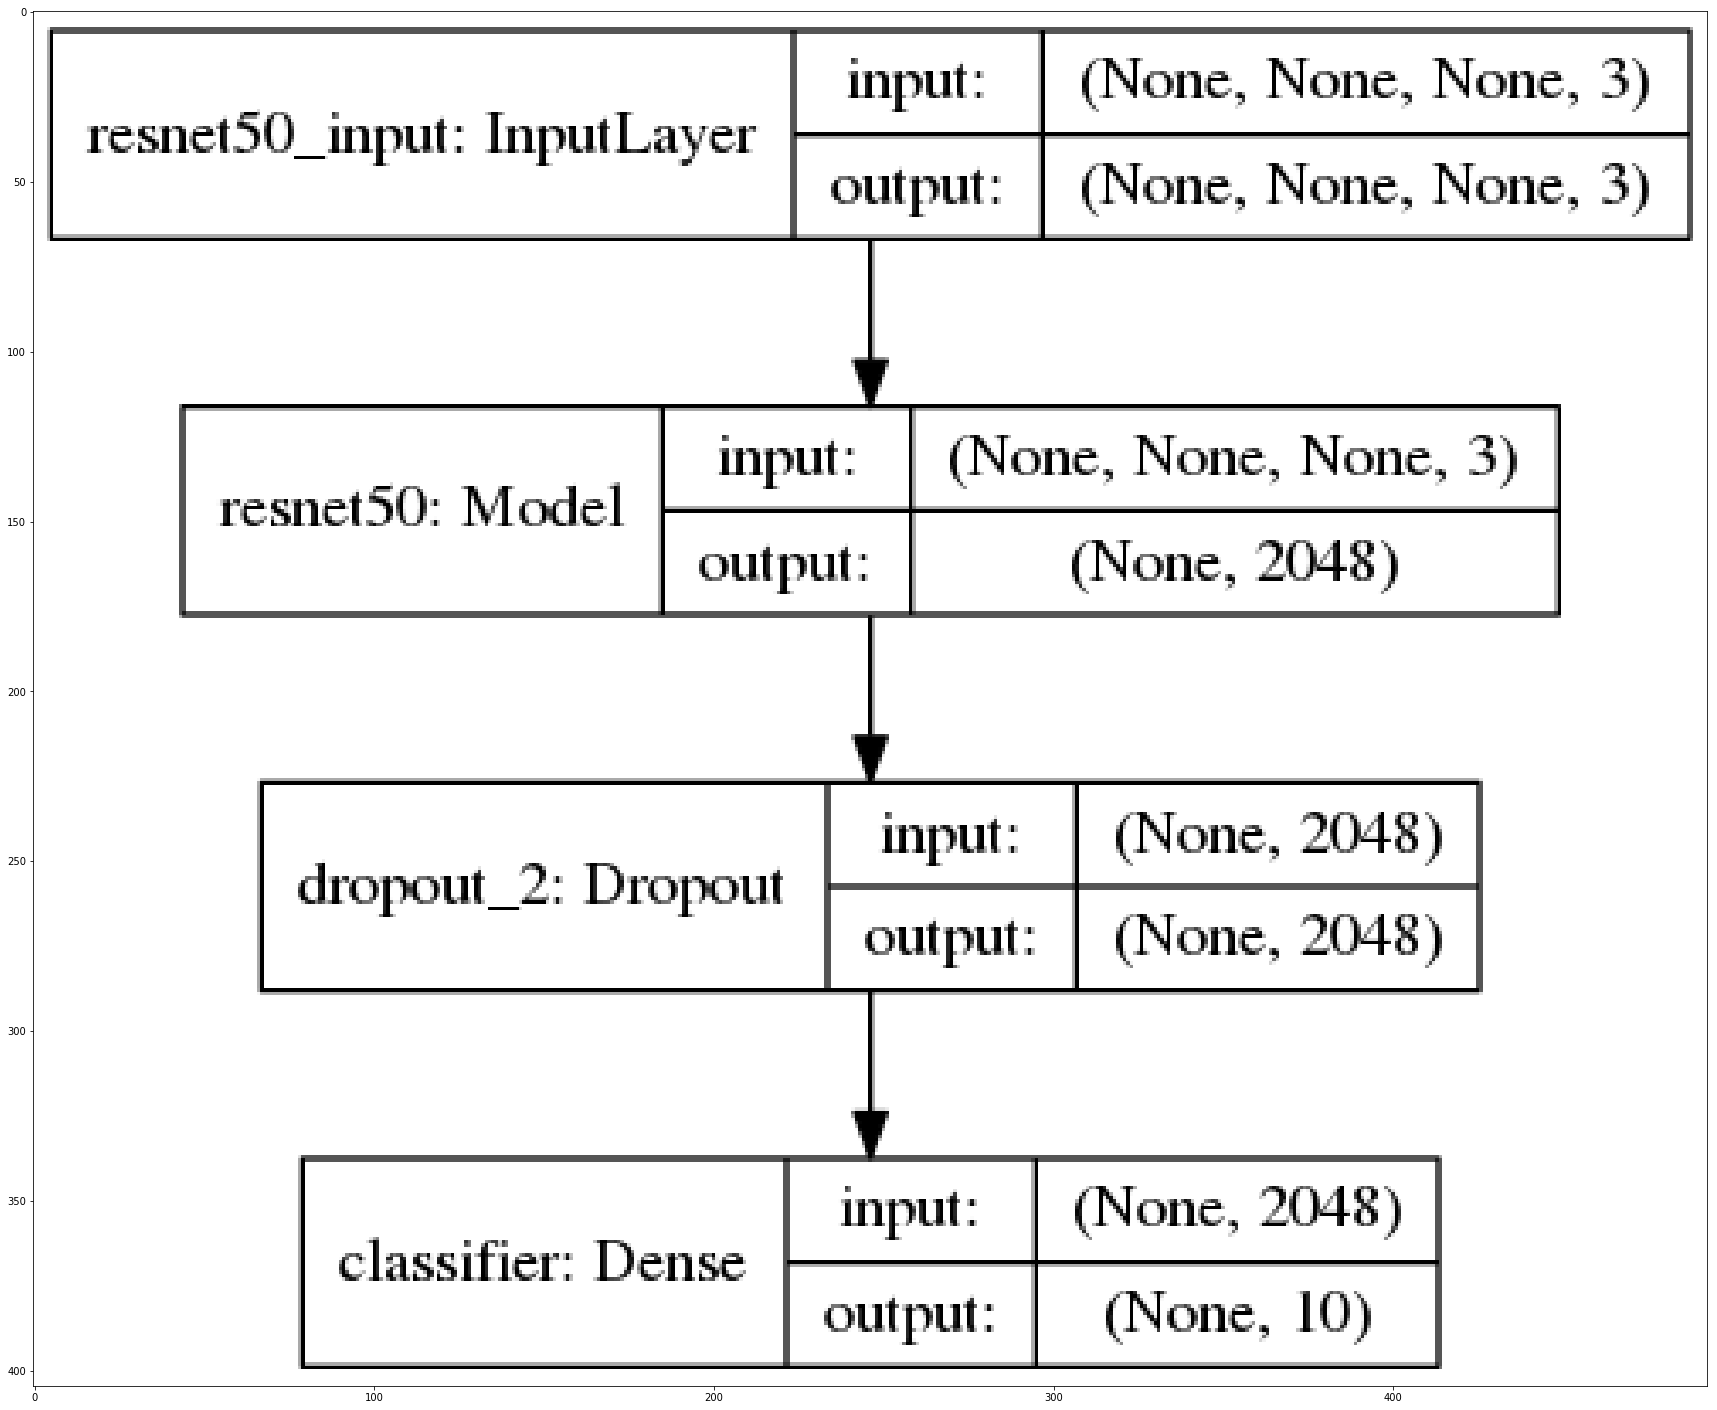

In [73]:
plot_model(tmodel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
plt.figure(figsize=(30,30))
plt.imshow(plt.imread('model_plot.png'))
print("Complete")

In [74]:
opt = SGD(lr=1e-2,decay=0.0001,momentum=0.9)
tmodel.compile(
    metrics=['categorical_accuracy'],
    optimizer='sgd',
    loss='categorical_crossentropy'
)
print("Model Compiled Ready For Training")

Model Compiled Ready For Training


In [75]:
best_weights = "/tmp/weights.hdf5"
checkpoint = ModelCheckpoint(
    best_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=True,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=15,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=batchsize,
    write_graph=True,
    write_grads=True,
    write_images=False,
)
reducelr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    mode='auto',
    min_delta=1e-3,
    min_lr=1e-3
)


callbacks = [checkpoint,earlystop,tensorboard]
print("CallBacks Ready!")

CallBacks Ready!


In [76]:
history = tmodel.fit_generator(
    trn_gen,
    steps_per_epoch=20,
    epochs=10,
    verbose=1,
    validation_data=val_gen,
    validation_steps=20,
    callbacks=callbacks
)
print("Model Trained")

Epoch 1/10
20/20 [==============================] - 46s 2s/step - loss: 2.3096 - categorical_accuracy: 0.2296 - val_loss: 1.1884 - val_categorical_accuracy: 0.6908

Epoch 00001: val_loss improved from inf to 1.18837, saving model to /tmp/weights.hdf5
Epoch 2/10
20/20 [==============================] - 30s 2s/step - loss: 1.5312 - categorical_accuracy: 0.4792 - val_loss: 0.5947 - val_categorical_accuracy: 0.8750

Epoch 00002: val_loss improved from 1.18837 to 0.59472, saving model to /tmp/weights.hdf5
Epoch 3/10
20/20 [==============================] - 38s 2s/step - loss: 1.0125 - categorical_accuracy: 0.7015 - val_loss: 0.4353 - val_categorical_accuracy: 0.9062

Epoch 00003: val_loss improved from 0.59472 to 0.43535, saving model to /tmp/weights.hdf5
Epoch 4/10
20/20 [==============================] - 34s 2s/step - loss: 0.8280 - categorical_accuracy: 0.7667 - val_loss: 0.3130 - val_categorical_accuracy: 0.9161

Epoch 00004: val_loss improved from 0.43535 to 0.31300, saving model to /t

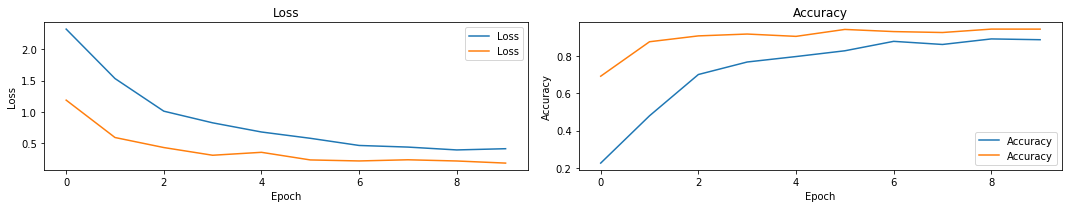

In [89]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].plot(history.history['loss'], label="Loss")
axes[0].plot(history.history['val_loss'], label="Loss")
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()


axes[1].plot(history.history['categorical_accuracy'], label="Accuracy")
axes[1].plot(history.history['val_categorical_accuracy'], label="Accuracy")
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.tight_layout()

plt.show()

In [90]:
tmodel_eval = tmodel.evaluate_generator(val_gen)
print("Tmodel: Evaluation: Test Loss", tmodel_eval[0])
print("Tmodel: Test Accuracy",tmodel_eval[1])

Tmodel: Evaluation: Test Loss 0.19638694515999625
Tmodel: Test Accuracy 0.9375


In [91]:
tmodel_json = tmodel.to_json()
with open("tmodel_monkey.json","w") as json_file:
    json_file.write(tmodel_json)
    
tmodel.save_weights("tmodel_monkey.h5")

print("Tmodel: Structure And Weights Saved")

Tmodel: Structure And Weights Saved


In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
LOG_DIR = './logs' # Here you have to put your log directory
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 8080 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 8080 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"